In [10]:
from core.gradient_descent import wolfe_conditions_search, point_number_terminate_condition, fixed_step_search
from core.quasi_newton_test_suite import *
%load_ext autoreload
%autoreload 2

from core.high_order_optimization import *
from core.optimizer_evaluator import *
from core.gradient_descent import *
from core.utils import *
from core.visualizer import *
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Нелинейная регрессия

Минимизируем функцию, представленную в виде $$
f(x) = \frac{1}{2} \sum\limits_{j = 1}^{m} r_j^2(x),
$$

Обозначим $r = (r_1, r_2, ... r_m)$

## Gauss-Newton метод
Метод основывается на итеративном решении уравнения $\nabla f (x) = 0$ методом Ньютона поиска 0 фукнции. Условие метода Ньютона переписывается в виде $\nabla^2 f(x_k) p = - \nabla f(x_k)$, где $x_k$ -- текущая точка, а $p$ -- искомое направление. Пользуясь специальным видом $f$, можно выписать $\nabla f$ и $\nabla^2 f$:
$\nabla f(x) = J(x)^T r(x)$ и $\nabla^2 f(x) = J(x)^T J(x) + \sum\limits_{j = 1}^m r_j(x) \nabla^2 r_j(x)$, где $J$ -- якобиан $r$.
Сделав предположение, что второе слагаемое сравнительно мало с первым в $\nabla^2 f$, сводим поиск направления к решению уравнения $J^T(x_k) J(x_k) p = - J^T(x_k) r(x_k)$. Уже вдоль этого направления можно делать линейный поиск.


## DogLeg метод

Подход trust-region, строим квадратичную модель, стандартным образом$^*$ расширяем/сужаем trust region.

Минимизация происходит так:
- Строиться шаг алгоритма Гаусса-Ньютона. Если он не выходит за границу доверительного шара, то делается такой шаг.
- Если шаг Гаусса-Ньютона вышел за границы, то ищится локальный минимум в направлении антиградиента (точка Коши).
- Если точка Коши выходит за границы шара, то делается шаг в точку пересечения шара и направления в точку Коши.
- Если точка Коши была внутри шара, то делается шаг в точку пересечения шара и направления из точки Коши в точку шага Гаусса-Ньютона.


In [3]:
f1 = lambda x: np.exp(x[0])
f2 = lambda x: np.sin(x[0])
f3 = lambda x: np.exp(-(x[0] + 1))
fs = [f1, f2, f3]

df1 = lambda x: np.array([np.exp(x[0])])
df2 = lambda x: np.array([np.cos(x[0])])
df3 = lambda x: np.array([-np.exp(-(x[0] + 1))])
dfs = [df1, df2, df3]

x0 = np.array([10])

termination = lambda f, points: len(points) > 20

p1 = gauss_newton(fs, dfs, x0, termination)
p2 = gauss_newton_with_approx_grad(fs, x0, termination)

print(f"symbolic grad argmin = {p1[-1]}, approx grad argmin = {p2[-1]}")

symbolic grad argmin = [-0.30823297], approx grad argmin = [-0.3083785]


In [153]:
f1 = generate_positive_definite_quadratic_form(2, 200, random_orthonormal_basis)
f2 = generate_positive_definite_quadratic_form(2, 320, random_orthonormal_basis)
residuals = [f1, f2]

df1 = f1.gradient_function()
df2 = f2.gradient_function()
gradients = [df1, df2]

dg_points = np.array(dogleg([f1, f2], [df1, df2], 10, wolfe_conditions_search(0.1, 0.9), np.array([-5.0, 5.0]), lambda f, ps: f(ps[-1]) < 1e-9))
len(dg_points)

23

# Сравнение с методами из предыдущих работ

In [154]:
f = lambda x: 0.5 * sum((r(x) ** 2 for r in residuals))
df = lambda x: sum((r(x) * g(x) for r, g in zip(residuals, gradients)))
gd_points = np.array(steepest_descent_rms_prop(0.9)(f, df, np.array([-5.0, 5.0]), fixed_step_search(1), lambda f, ps: f(ps[-1]) < 1e-9))
len(gd_points)

318

Best value found: x* = [-0.0002403  0.0002403] with f(x*) = 9.271283723486855e-10


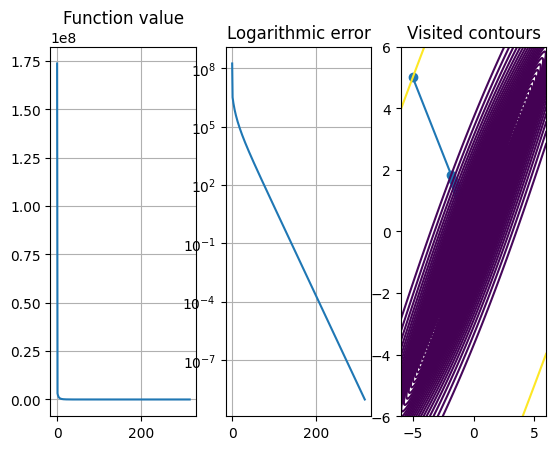

In [155]:
visualize_optimizing_process(f, SearchRegion2d((-6., 6.), (-6., 6.)), gd_points, 0);

Best value found: x* = [0.0012898 0.0012332] with f(x*) = 2.1680076869461096e-10


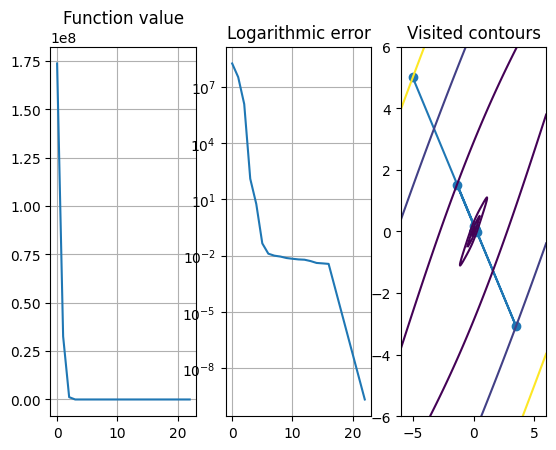

In [156]:
visualize_optimizing_process(f, SearchRegion2d((-6., 6.), (-6., 6.)), dg_points, 0);

# Для большей размерности

In [12]:
non_linear_solvers = [
    ("RMSProp", lambda residuals, gradients, f, df, x0, term: steepest_descent_rms_prop(0.9)(f, df, x0, fixed_step_search(1), term)),
    ("Adam", lambda residuals, gradients, f, df, x0, term: steepest_descent_adam(0.9, 0.9)(f, df, x0, fixed_step_search(1), term)),
    ("DogLeg", lambda residuals, gradients, f, df, x0, term: dogleg(residuals, gradients, 10, wolfe_conditions_search(0.1, 0.9), x0, term)),
    ("Gauss-Newton", lambda residuals, gradients, f, df, x0, term: gauss_newton(residuals, gradients, x0, term))
]

In [13]:
evaluate_methods_on_square_sums(non_linear_solvers)

—————— Many Dimensions Sq ——————
Iterations until convergence for 2×2: 330
Iterations until convergence for 7×7: 335
Iterations until convergence for 8×8: 343
Iterations until convergence for 10×10: 344
Iterations until convergence for 2×2: 224
Iterations until convergence for 7×7: 304
Iterations until convergence for 8×8: 320
Iterations until convergence for 10×10: 329
Iterations until convergence for 2×2: 11
Iterations until convergence for 7×7: 12
Iterations until convergence for 8×8: 12
Iterations until convergence for 10×10: 12
Iterations until convergence for 2×2: 12
Iterations until convergence for 7×7: 12
Iterations until convergence for 8×8: 13
Iterations until convergence for 10×10: 13
+----------+-----------+--------+----------+----------------+
| dim      |   RMSProp |   adam |   DogLeg |   Gauss-Newton |
+==========+===========+========+==========+================+
| (2, 2)   |       330 |    224 |       11 |             12 |
+----------+-----------+--------+----------+---